# Geospatial Data Exploration, Analysis, and Visualization
### Some core concepts and geospatial data science approaches for ICESat data analysis*
*Not intended for billions of ATL03 points

ICESat-2 hackweek  
June 12, 2020  
David Shean

You've used the NSIDC API, pulled your granules, extracted the relevant records and fields, and done some initial QA/QC.  Now what?  

Let's work through some Python geospatial data science tools that can help with analysis and visualization of these point data, enabling exploratory data analysis and data-driven discovery.  

# Objectives

* Review commong fundamental concepts in geospatial analysis (e.g. coordinate systems, projections, datums, geometry types)
* Learn basic geospatial data manipulation and exploration with a relatively small, clean ICESat GLAS dataset
* Use modern data science tools (pandas) for basic data exploration, interpretation, and visualization
* Explore different approaches for spatial aggregation of points - groupby attribute, spatial join by polygon, hex bins
* Learn how to sample a raster at point locations
* Analyze elevation change using sparse laser altimetry data over mountain glaciers

# Tutorial prep

1. Log on to the event Jupyterhub: https://icesat-2.hackweek.io

1. Open a terminal in Jupyterlab ("+" icon in upper left corner, then click on the terminal icon)

1. Navigate to local directory where you want to store tutorial material (home directory by default):  
`cd ~/tutorials`

1. If you haven't dont so, clone the repo:  
`git clone https://github.com/ICESAT-2HackWeek/geospatial-analysis.git`

1. Enter the tutorial directory:  
`cd geospatial-analysis`

    1. If you cloned earlier in the week, you will need to pull latest changes:
`git pull`

**Remeber to post all questions to the `#questions` channel on the Slack workspace**

# Introduction

## Quick Zoom poll:
In the Zoom Participants panel, use the Yes (green) or No (red) response to answer the following question: 

**Have you ever taken a GIS course?**

## GIS Basics
>A geographic information system (GIS) is a framework for gathering, managing, and analyzing data. Rooted in the science of geography, GIS integrates many types of data. It analyzes spatial location and organizes layers of information into visualizations using maps and 3D scenes. ​With this unique capability, GIS reveals deeper insights into data, such as patterns, relationships, and situations—helping users make smarter decisions.

https://www.esri.com/en-us/what-is-gis/overview

Primary data types:
* Vector - points, lines, polygons; shapefiles
    * https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html
* Raster - images, gridded data; GeoTiff

Concepts (with specific geopandas doc):
* Coordinate Systems - map projection and datum: https://geopandas.org/projections.html
* Geometry manipulation/operations: 
    * https://geopandas.org/geometric_manipulations.html
    * https://geopandas.org/set_operations.html

## The Scientific Python landscape

* Python
* Jupyter/iPython
* NumPy, Pandas, Matplotlib, SciPy
* xarray, scikit-learn

One (aging) interpretation of this stack:

![2017 Scientific Python Stack](https://devopedia.org/images/article/60/7938.1587985662.jpg)
Slide from Jake VanderPlas’s presentation at PyCon 2017, entitled “The Unexpected Effectiveness of Python in Science.”

## The Geospatial Python landscape
* GDAL/OGR, GEOS, PROJ
* shapely, fiona, pyproj
* xarray, geopandas, rasterio, cartopy
* rioxarray/salem, PDAL

[Insert shiny new figure here]

## Complementary approaches for ICESat-2 data

1. Efficient, scalable processing of huge point datasets
    * Mostly NumPy
    * Basic array manipulations
    * Array size limited by memory - can chunk with Dask
2. Higher-level data science - *analysis, interpetation, and visualization*
    * NumPy under the hood
    * Convenience and flexibility comes with small performance hit
    * Labels make life easier (don't need to remember integer indices)

Here, we're going to explore #2 with an existing dataset.

At the end of the day, most applications just need clean (x,y,z,t) points.

As with all things in the *nix/open-source/Python world, there are always multiple approaches that can be used to accomplish the same goals.  The user must decide on an approach based on complexity, time constraints, etc.

# ICESat GLAS Background
The NASA Ice Cloud and land Elevation Satellite ([ICESat](https://icesat.gsfc.nasa.gov/icesat/)) was a NASA mission carrying the Geosciences Laser Altimeter System (GLAS) instrument: a space laser, pointed down at the Earth (and unsuspecting Earthlings).  

It measured surface elevations by precisely tracking laser pulses emitted from the spacecraft at a rate of 40 Hz (a new pulse every 0.025 seconds).  These pulses traveled through the atmosphere, reflected off the surface, back up through the atmosphere, and into space, where some small fraction of that original energy was received by a telescope on the spacecraft.  The instrument electronics precisely recorded the time when these intrepid photons left the instrument and when they returned.  The position and orientation of the spacecraft was precisely known, so the two-way traveltime (and assumptions about the speed of light and propagation through the atmosphere) allowed for precise forward determination of the spot on the Earth's surface (or cloud tops, as was often the case) where the reflection occurred.  The laser spot size varied during the mission, but was ~70 m in diameter. 

ICESat collected billions of measurements from 2003 to 2009, and was operating in a "repeat-track" mode that sacrificed spatial coverage for more observations along the same ground tracks over time.  One primary science focus involved elevation change over the Earth's ice sheets.  It allowed for early measurements of full Antarctic and Greenland ice sheet elevation change, which offered a detailed look at spatial distribution and rates of mass loss, and total ice sheet contributions to sea level rise.  

There were problems with the lasers during the mission, so it operated in short campaigns lasting only a few months to prolong the full mission lifetime.  While the primary measurements focused on the polar regions, many measurements were also collected over lower latitudes, to meet other important science objectives (e.g., estimating biomass in the Earth's forests, observing sea surface height/thickness over time). 

# Part 1: Sample GLAS dataset for CONUS
A few years ago, I wanted to evaluate ICESat coverage of the Continental United States (CONUS).  The primary application was to extract a set of accurate control points to co-register a large set of high-resolution digital elevation modoels (DEMs) derived from satellite stereo imagery.  I wrote some Python/shell scripts to download, filter, and process all of the GLAH14 granules in parallel ([https://github.com/dshean/icesat_tools](https://github.com/dshean/icesat_tools)).

The high-level workflow is here: https://github.com/dshean/icesat_tools/blob/master/glas_proc.py#L24.  These tools processed each HDF5 (H5) file and wrote out csv files containing only the “good” points. These csv files were concatenated to prepare the single input csv (`GLAH14_tllz_conus_lulcfilt_demfilt.csv`) that we will use for this tutorial.  

The csv contains ICESat GLAS shots that passed the following filters:
* Within some buffer (~110 km) of mapped glacier polygons from the [Randolph Glacier Inventory (RGI)](https://www.glims.org/RGI/)
* Returns from exposed bare ground (landcover class 31) or snow/ice (12) according to a 30-m Land-use/Land-cover dataset (2011 NLCD, https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover)
* Elevation values within some threshold (200 m) of elevations sampled from an external reference DEM (void-filled 1/3-arcsec [30-m] SRTM-GL1, https://lpdaac.usgs.gov/products/srtmgl1v003/), used to remove spurious points and returns from clouds.
* Various other ICESat-specific quality flags (see comments in `glas_proc.py` for details)

The final file contains a relatively small subset (~65K) of the total shots in the original GLAH14 data granules from the full mission timeline (2003-2009).  The remaining points should represent returns from the Earth's surface with reasonably high quality, and can be used for subsequent analysis.

## Wait, I thought this was an ICESat-**2** hackweek?

Note that we could (and should!) swap similarly processed/filtered ATL06 points over CONUS for this tutorial.  I did not have time to do this before the hackweek, but it would make a great project (nudge).  After opening this updated file with Pandas, it should mostly be a matter of updating field names throughout the notebook.

# Import necessary modules

In [1]:
import os
import requests
import zipfile

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Magic function to enable interactive plotting (zoom/pan) in Jupyter notebook
#If running locally, this would be `%matplotlib notebook`, but since we're using Juptyerlab, we use widget
%matplotlib widget
#%matplotlib inline

In [5]:
#Define path to sample GLAS data
glas_fn = 'GLAH14_tllz_conus_lulcfilt_demfilt.csv'

In [6]:
#Quick check of csv file contents
!head $glas_fn

decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
2003.13957078, 731266.9433448168, 44.157897, -105.356562, 1398.51, 1400.52, 0.33, 31
2003.13957081, 731266.9433462636, 44.150175, -105.358116, 1387.11, 1384.64, 0.43, 31
2003.13957081, 731266.9433465529, 44.148632, -105.358427, 1392.83, 1383.49, 0.28, 31
2003.13957081, 731266.9433468423, 44.147087, -105.358738, 1384.24, 1382.85, 0.84, 31
2003.13957081, 731266.9433471316, 44.145542, -105.359048, 1369.21, 1380.24, 1.73, 31
2003.13957081, 731266.9433474210, 44.143996, -105.359359, 1366.60, 1375.23, 1.60, 31
2003.13957081, 731266.9433506038, 44.126969, -105.362876, 1355.14, 1379.38, 2.17, 31
2003.13957084, 731266.9433604418, 44.074358, -105.373549, 1369.53, 1391.71, 2.88, 31
2003.13957084, 731266.9433607311, 44.072806, -105.373864, 1380.02, 1387.79, 0.45, 31


# Pandas

Trust me, you should learn how to use `Pandas`, regardless of your ICESat-2 application.  

A significant portion of the Python data science ecosystem is based on Pandas and/or Pandas data models.

>pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive. It aims to be the fundamental high-level building block for doing practical, real world data analysis in Python. Additionally, it has the broader goal of becoming the most powerful and flexible open source data analysis / manipulation tool available in any language. It is already well on its way towards this goal.

https://github.com/pandas-dev/pandas#main-features

If you are working with tabular data (rows and columns, like a csv or spreadsheet), especially time series data, please use pandas.
* A better way to deal with tabular data, built on top of NumPy arrays
* With NumPy, we had to remember which column number (e.g., 3, 4) represented each variable (lat, lon, glas_z, etc)
* Pandas allows you to store data with different types, and then reference using more meaningful labels
    * NumPy: `glas_np[:,4]`
    * Pandas: `glas_df['glas_z']`
* A good "10-minute" reference with examples: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

If you are working with more complex data, like collections of tabular time series data from 100s of met stations or netCDF model output, you can use [`xarray` package](http://xarray.pydata.org/en/stable/), which extends the `pandas` data model to n-dimensions.

## Load the csv file with Pandas
* Note that pandas has excellent readers for most common file formats: https://pandas.pydata.org/pandas-docs/stable/reference/io.html

In [7]:
glas_df = pd.read_csv(glas_fn)

## That was easy.  Let's inspect the returned `DataFrame` object

In [8]:
glas_df

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31
...,...,...,...,...,...,...,...,...
65231,2009.775995,733691.238340,37.896222,-117.044399,1556.16,1556.43,0.00,31
65232,2009.775995,733691.238340,37.897769,-117.044675,1556.02,1556.43,0.00,31
65233,2009.775995,733691.238340,37.899319,-117.044952,1556.19,1556.44,0.00,31
65234,2009.775995,733691.238340,37.900869,-117.045230,1556.18,1556.44,0.00,31


## Check data types
* Can use the DataFrame `info` method

In [9]:
glas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65236 entries, 0 to 65235
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   decyear    65236 non-null  float64
 1   ordinal    65236 non-null  float64
 2   lat        65236 non-null  float64
 3   lon        65236 non-null  float64
 4   glas_z     65236 non-null  float64
 5   dem_z      65236 non-null  float64
 6   dem_z_std  65236 non-null  float64
 7   lulc       65236 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 4.0 MB


## Get the column labels
* Can use the DataFrame `columns` attribute

In [10]:
glas_df.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc'],
      dtype='object')

If you are new to Python and object-oriented programming, take a moment during the break to consider the [difference between the methods and attributes](https://stackoverflow.com/questions/46312470/difference-between-methods-and-attributes-in-python) of the DataFrame, and how both are accessed. 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

If this is confusing, ask your neighbor or instructor.

## Preview records using DataFrame `head` and `tail` methods

In [11]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


In [12]:
glas_df.tail()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
65231,2009.775995,733691.238340,37.896222,-117.044399,1556.16,1556.43,0.0,31
65232,2009.775995,733691.238340,37.897769,-117.044675,1556.02,1556.43,0.0,31
65233,2009.775995,733691.238340,37.899319,-117.044952,1556.19,1556.44,0.0,31
65234,2009.775995,733691.238340,37.900869,-117.045230,1556.18,1556.44,0.0,31
65235,2009.775995,733691.238341,37.902420,-117.045508,1556.32,1556.44,0.0,31


## Compute the mean and standard deviation for all values in each column

In [13]:
glas_df.mean()

decyear        2005.945322
ordinal      732291.890372
lat              40.946798
lon            -115.040612
glas_z         1791.494167
dem_z          1792.260964
dem_z_std         5.504748
lulc             30.339444
dtype: float64

In [14]:
glas_df.std()

decyear         1.729573
ordinal       631.766682
lat             3.590476
lon             5.465065
glas_z       1037.183482
dem_z        1037.925371
dem_z_std       7.518558
lulc            3.480576
dtype: float64

## Apply a custom function to each column
* For this example, let's define a function to compute the Normalized Median Absolute Deviation (NMAD)
* We will then use the Pandas `apply` method to compute the NMAD for all values in each column
* https://en.wikipedia.org/wiki/Median_absolute_deviation
* For a normal distribution, this is equivalent to the standard deviation. But for data containing outliers, it is a more robust representation of variability. 

In [15]:
def nmad(a, c=1.4826):
    return np.median(np.fabs(a - np.median(a))) * c

In [16]:
glas_df.apply(nmad)

decyear        2.066488
ordinal      755.079010
lat            3.885421
lon            5.798237
glas_z       632.580942
dem_z        632.136162
dem_z_std      2.001510
lulc           0.000000
dtype: float64

*Note: the NMAD function is now distributed with `scipy.stats`: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_absolute_deviation.html*

Can also use and `apply` functions imported from modules

In [17]:
import scipy.stats

In [18]:
glas_df.apply(scipy.stats.median_absolute_deviation)

decyear        2.066488
ordinal      755.079010
lat            3.885421
lon            5.798237
glas_z       632.580942
dem_z        632.136162
dem_z_std      2.001510
lulc           0.000000
dtype: float64

## Print quick stats for entire DataFrame with the `describe` method

In [19]:
glas_df.describe()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
count,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000
mean,2005.945322,732291.890372,40.946798,-115.040612,1791.494167,1792.260964,5.504748,30.339444
std,1.729573,631.766682,3.590476,5.465065,1037.183482,1037.925371,7.518558,3.480576
min,2003.139571,731266.943345,34.999455,-124.482406,-115.550000,-114.570000,0.000000,12.000000
25%,2004.444817,731743.803182,38.101451,-119.257599,1166.970000,1168.240000,0.070000,31.000000
50%,2005.846896,732256.116938,39.884541,-115.686241,1555.730000,1556.380000,1.350000,31.000000
75%,2007.223249,732758.486046,43.453565,-109.816475,2399.355000,2400.072500,9.530000,31.000000
max,2009.775995,733691.238341,48.999727,-104.052336,4340.310000,4252.940000,49.900000,31.000000


Useful, huh?  Note that the `50%` statistic is the median.

## Use the Pandas plotting functionality to create a 2D scatterplot of `glas_z` values
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.scatter.html
* Note that labels and colorbar are automatically plotted!
* Can adjust the size of the points using the `s=1` keyword
* Can experiment with different color ramps:
    * https://matplotlib.org/examples/color/colormaps_reference.html (I prefer `inferno`)

#### Color ramps
Information on how to choose a good colormap for your data: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
Another great resource (Thanks @fperez!): https://matplotlib.org/cmocean/  
**TL;DR** Don't use `jet`, use a perceptually uniform colormap for linear variables like elevation. Use a diverging color ramp for values where sign is important.

In [20]:
glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_z', s=1, cmap='inferno');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Experiment by changing the variable represented with the color ramp
* Try `decyear` or other columns to quickly visualize spatial distribution of these values.

In [21]:
glas_df.plot(x='lon', y='lat', kind='scatter', c='decyear', s=1, cmap='inferno');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Create a histogram that shows the number of points vs time (`decyear`)

In [22]:
#Determine number of bins needed to provide weekly resolution
nbins = int(50 * np.ptp(glas_df['decyear'].values))
nbins

331

In [23]:
ax = glas_df.hist('decyear', bins=nbins)[0,0]
ax.set_ylabel('Number of ICESat points')
ax.set_title('Weekly usable ICESat point count over CONUS');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Note that we can resolve the distinct campaigns during the ICESat mission (each ~1-2 months long).

## Create a histogram of all `glas_z` elevation values

In [24]:
#Determine number of bins needed for 20 m elevation bins
binwidth = 20
nbins = int(np.ptp(glas_df['glas_z'].values)/binwidth)
nbins

222

In [25]:
glas_df.hist('glas_z', bins=nbins);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Wait a minute...negative elevations!?  Who calibrated this thing? C'mon NASA.

## A note on vertical datums

Note that some elevations are less than 0 m.  How can this be?

The `glas_z` values are height above (or below) the WGS84 ellipsoid. This is not the same vertical datum as mean sea level (roughly approximated by a geoid model).

A good resource explaining the details: https://vdatum.noaa.gov/docs/datums.html

## How many GLAS points have a negative `glas_z` value?

In [26]:
glas_df['glas_z'] < 0

0        False
1        False
2        False
3        False
4        False
         ...  
65231    False
65232    False
65233    False
65234    False
65235    False
Name: glas_z, Length: 65236, dtype: bool

In [27]:
(glas_df['glas_z'] < 0).value_counts()

False    62136
True      3100
Name: glas_z, dtype: int64

## Check spatial distribution of points below 0 (height above WGS84 ellipsoid)
* Create a scatterplot only using points with negative values
* Adjust the color ramp bounds to bring out more detail for these points
    * hint: see the `vmin` and `vmax` arguments for the `plot` function
* What do you notice about these points? (may be tough without more context, like coastlines and state boundaries or a tiled basemap - we'll learn how to incorporate these later)

In [28]:
glas_df[glas_df['glas_z'] < 0]

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
465,2003.143756,731268.470836,46.279402,-124.035117,-23.42,-22.25,0.81,31
466,2003.143756,731268.470836,46.282470,-124.035774,-23.39,-21.81,0.52,31
467,2003.143756,731268.470838,46.291775,-124.037745,-23.44,-23.53,0.00,31
468,2003.143756,731268.470838,46.293329,-124.038072,-23.11,-23.54,0.00,31
469,2003.143756,731268.470838,46.294880,-124.038399,-23.98,-22.78,0.26,31
...,...,...,...,...,...,...,...,...
65068,2009.771999,733689.779542,46.391823,-123.960255,-23.53,-23.78,0.00,31
65069,2009.771999,733689.779542,46.390275,-123.960584,-23.23,-23.79,0.00,31
65070,2009.771999,733689.779543,46.387179,-123.961247,-22.80,-23.79,0.00,31
65071,2009.771999,733689.779543,46.385631,-123.961580,-23.14,-23.80,0.00,31


In [29]:
glas_df[glas_df['glas_z'] < 0].plot(x='lon', y='lat', kind='scatter', c='dem_z', s=1, cmap='inferno', vmin=-30, vmax=0);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Geoid offset grids
PROJ and GDAL use raster grids of the horizontal and vertical offsets between the WGS84 ellipsoid and different geoid models.

These grids are now hosted on the cloud: https://cdn.proj.org/, which enables on-the-fly transformations with GDAL!

Here's the EGM96 offset grid.  It shows the height differene between the WGS84 ellipsoid (simple shape model of the Earth) and the EGM96 geoid, which approximates a geopotential (gravitational) surface, approximately euivalent to mean sea level 

![EGM96 geoid offset grid](https://raw.githubusercontent.com/UW-GDA/gda_course_2020/master/resources/sample_img/egm96_offset.png)  
(Source GeoTiff: https://cdn.proj.org/us_nga_egm96_15.tif)


Note values for CONUS.  

A lot of the points with elevation < 0 m in the above plot are near coastal sites, roughly near mean sea level.  We see that the geoid offset (difference between WGS84 ellipsoid and EGM96 geoid in this case) for CONUS is roughly -20 m.  So the ICESat GLAS point elevations near the coast are roughly -20 m relative to the ellipsoid, even though they are 0 m relative to the geoid (approximately mean sea level).  These concepts around datums can be a bit confusing, so please ask questions.

Note that ICESat-2 includes elevation values relative to the EGM2008 geoid model to provide orthometric heights - a more recent, more accurate, more detailed geoid model compared to EGM96.

# Part 2: More Pandas, Outlier Removal, Groupby

## Compute the elevation difference between ICESat `glas_z` and SRTM `dem_z` values

Earlier, I mentioned that I had sampled the SRTM DEM for each GLAS shot.  Let's compute the difference and store in a new column in our DataFrame called `glas_srtm_dh`

Remember the order of this calculation (if the difference values are negative, which dataset is higher elevation?)

In [30]:
glas_df['glas_srtm_dh'] = glas_df['glas_z'] - glas_df['dem_z']
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03


## Compute the time difference between ICESat point timestamp and the SRTM timestamp
* Store in a new column named `glas_srtm_dt`
* The SRTM data were collected between February 11-22, 2000
    * Can assume a constant decimal year value of 2000.112 for now

In [31]:
#February 11-22, 2000
srtm_decyear = 2000.112
glas_df['glas_srtm_dt'] = glas_df['decyear'] - srtm_decyear
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571


## Compute *apparent* annualized elevation change rate ($\frac{dh}{dt}$ in meters per year) from these new columns
* This will be rate of change between the SRTM timestamp (2000) and each GLAS point timestamp (2003-2009)

In [32]:
glas_df['glas_srtm_dhdt'] = glas_df['glas_srtm_dh']/glas_df['glas_srtm_dt']
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185


## Create a scatterplot of the difference values
* Use a symmetrical `RdBu` (Red to Blue) color ramp
* Set the color ramp limits using `vmin` and `vmax` keyword arguments to be symmetrical about 0 z

In [33]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-10, vmax=10)
ax.set_ylabel('latitude');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-50, vmax=50)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Compute some descriptive statistics
* Why might we have a non-zero mean/median difference?

In [35]:
print(glas_df['glas_srtm_dh'].mean())
print(glas_df['glas_srtm_dh'].std())

-0.7667968606291014
12.36334152209537


In [36]:
print(glas_df['glas_srtm_dh'].median())
print(nmad(glas_df['glas_srtm_dh']))

-0.7999999999999545
2.4314640000001484


## Create a histogram of the difference values

In [37]:
f, ax = plt.subplots()
glas_df.hist('glas_srtm_dh', ax=ax, bins=128, range=(-10,10));
ax.axvline(0, color='k')
ax.axvline(glas_df['glas_srtm_dh'].median(), color='r');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Create a scatterplot of elevation difference `glas_srtm_dh` values vs elevation values
* `glas_srtm_dh` should be on the y-axis
* `glas_z` values on the x-axis

In [38]:
ax = glas_df.plot('glas_z', 'glas_srtm_dh', kind='scatter', s=1)
#Add a horizontal line at 0
ax.axhline(0, color='k', lw=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Remove outliers
The initial filter in `glas_proc.py` removed GLAS points with absolute elevation difference >200 m compared to the SRTM elevations.  We expect most real elevation change signals to be less than this for the given time period.  But clearly some outliers remain.

Let's design and apply a simple filter that removes outliers.  One option is to define outliers as values outside some absolute threshold. Can set this threshold as some multiple of the standard deviation (e.g., `3*std`). Can also use quantile or percentile values for this.

In [39]:
print("Mean difference:", glas_df['glas_srtm_dh'].mean())
thresh = 3.5 * glas_df['glas_srtm_dh'].std()
print("3.5 * std:", thresh)

Mean difference: -0.7667968606291014
3.5 * std: 43.271695327333795


In [40]:
idx = (glas_df['glas_srtm_dh'] - glas_df['glas_srtm_dh'].mean()).abs() <= thresh
glas_df_fltr = glas_df[idx]
print("Number of points before filter:", glas_df.shape[0])
print("Number of points after filter:", glas_df_fltr.shape[0])

Number of points before filter: 65236
Number of points after filter: 64589


In [41]:
clim = thresh
f, axa = plt.subplots(1,2, figsize=(10,4))
#Outliers plotted in black
glas_df.plot(ax=axa[1], x='glas_z', y='glas_srtm_dh', kind='scatter', s=1, color='k', label='Outliers')
glas_df_fltr.plot(ax=axa[0], x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-clim, vmax=clim)
glas_df_fltr.plot(ax=axa[1], x='glas_z', y='glas_srtm_dh', kind='scatter', s=1, c='orange', label='Inliers')
glas_df[~idx].plot(ax=axa[0], x='lon', y='lat', kind='scatter', color='k', s=1, legend=False)
axa[1].axhline(0,color='k')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Active remote sensing sanity check

Even after removing outliers, there are still some big differences between the SRTM and GLAS elevation values.  

* Do you see systematic differences between the glas_z and dem_z values?
* Any clues from the scatterplot? (e.g., do some tracks (north-south lines of points) display systematic bias?)
* Brainstorm some ideas about what might be going on here.  Think about the nature of each sensor:
    * ICESat was a Near-IR laser (1064 nm wavelength) with a big ground spot size (~70 m in diameter)
        * Timestamps span different seasons between 2003-2009
    * SRTM was a C-band radar (5.3 GHz, 5.6 cm wavelength) with approximately 30 m ground sample distance (pixel size)
        * Timestamp was February 2000
        * Data gaps (e.g., radar shadows, steep slopes) were filled with ASTER GDEM2 composite, which blends DEMs acquired over many years ~2000-2014
* Consider different surfaces and how the laser/radar footprint might be affected:
    * Flat bedrock surface
    * Dry sand dunes
    * Steep montain topography like the Front Range in Colorado  
    * Dense vegetation of the Hoh Rainforest in Olympic National Park

## Let's check to see if differences are due to our land-use/land-cover (LULC) classes
* Determine the unique values in the `lulc` column (hint: see the `value_counts` method)
* In the introduction, I mentioned that I initially preserved only two classes for these GLAS points (12 - snow/ice, 31 - barren land), so this isn't going to help us over forests:
    * https://www.mrlc.gov/data/legends/national-land-cover-database-2011-nlcd2011-legend

In [42]:
glas_df['lulc'].value_counts()

31    62968
12     2268
Name: lulc, dtype: int64

## Use Pandas `groupby` to compute stats for the LULC classes
* https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
* This is one of the most powerful features in Pandas, efficient grouping and analysis based on attributes
* Compute mean, median and std of the difference values (glas_z - dem_z) for each LULC class
* Do you see a difference between values over glaciers vs bare rock?

In [43]:
glas_df[['glas_srtm_dh', 'lulc']].groupby('lulc').mean()

,glas_srtm_dh
lulc,
12,-2.039493
31,-0.720957


In [44]:
#Statistics for full dataset
glas_df[['glas_srtm_dh', 'lulc']].groupby('lulc').agg(['mean', 'std', 'median', nmad])

glas_srtm_dh                            
             mean        std median      nmad
lulc                                         
12      -2.039493  14.920269 -0.965  7.450065
31      -0.720957  12.258978 -0.800  2.327682

In [45]:
#Statistics for filtered dataframe (after removing outliers)
glas_df_fltr[['glas_srtm_dh', 'lulc']].groupby('lulc').agg(['mean', 'std', 'median', nmad])

glas_srtm_dh                            
             mean        std median      nmad
lulc                                         
12      -2.186099  10.140636 -0.915  7.309218
31      -0.985611   6.577751 -0.800  2.283204

In [46]:
for title, group in glas_df_fltr.groupby('lulc'):
    group.plot(x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-10, vmax=10, title='LULC %i' % title)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Part 3: Geopandas Intro

pandas is great, but what if we want to do some geospatial operations - like reproject our points or compute the intersection between Point and Polygon features?

Enter Geopandas - all the great things about pandas, plus geo! (http://geopandas.org/).

>"GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting."

>"GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS."

Under the hood, GeoPandas is `pandas` plus some other core geospatial packages:
* `shapely` for geometry operations (https://shapely.readthedocs.io/en/stable/manual.html)
* `fiona` for reading/writing GIS file formats (https://fiona.readthedocs.io/en/latest/manual.html)
* `pyproj` for projections and coordinate system transformations (http://pyproj4.github.io/pyproj/stable/)

Under those hoods are lower-level geospatial libraries (GEOS, GDAL/OGR, PROJ4) that provide a foundation for most GIS software (open-source and commercial).  I encourage you to explore these - I guarantee you will learn something valuable.

For now, let's explore some basic geopandas functionality.

## Convert pandas `DataFrame` to geopandas `GeoDataFrame`
To do this, we need to create a new column containing standardized `geometry` objects (e.g., `Point`, `Polygon`) for each record in the DataFrame. 

https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

## Convert the Pandas `DataFrame` to a GeoPandas `GeoDataFrame`
* https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
* Careful about lon and lat order!
* Define coordinate reference system (4326 is geographic lat/lon on WGS84 Ellispoid) 
* Run a quick `head()` to make sure everything looks good
* Note the new `geometry` column of the GeoDataFrame

In [47]:
glas_gdf = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']), crs='EPSG:4326')

In [48]:
type(glas_gdf)

geopandas.geodataframe.GeoDataFrame

In [49]:
type(glas_df)

pandas.core.frame.DataFrame

In [50]:
#Same `head()` method works on a GeoDataFrame! inherited from Pandas DataFrame
glas_gdf.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (-105.35656 44.15790)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (-105.35812 44.15017)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (-105.35843 44.14863)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (-105.35874 44.14709)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (-105.35905 44.14554)


In [51]:
#But we have additional attributes/methods in a GeoDataFrame
glas_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create a quick 2D scatterplot

Like a Pandas DataFrame, a GeoDataFrame has convenience plotting function that is built on matlplotlib

In [52]:
glas_gdf.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

OK, looks like a scatterplot.  But let's plot the elevation values with a color ramp.  
To do this, just specify the column name as the first argument to `plot`:

In [53]:
glas_gdf.plot('glas_z', markersize=1, cmap='inferno', legend=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Load and plot state polygons for context


Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url that points to a GeoJSON file somewhere on the web, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

We've heard GeoJSON mentioned a few times this week.  It's a great format.  If you are unfamiliar: https://en.wikipedia.org/wiki/GeoJSON

In [54]:
#1:5000000 scale polygons
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#1:500000 scale polygons (larger file, more vertices)
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'

In [55]:
states_gdf = gpd.read_file(states_url)

### Inspect State GeoDataFrame
Note that some geometry entries are tuples of POLYGON objects - these are states with islands or rings

In [56]:
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


### Limit to Lower48

In [57]:
idx = states_gdf['NAME'].isin(['Alaska','Puerto Rico','Hawaii'])
states_gdf = states_gdf[~idx]

In [58]:
ax = glas_gdf.plot('glas_z', markersize=1, cmap='inferno', legend=True)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# RGI glacier polygons

Let's grab some glacier outline poygons from the Randolph Glacier Inventory (RGI) v6.0: https://www.glims.org/RGI/

In [59]:
#Fetch the zip file for Region 02 (Western North America)
rgi_zip_fn = '02_rgi60_WesternCanadaUS.zip'

if not os.path.exists(rgi_zip_fn):
    url = 'https://www.glims.org/RGI/rgi60_files/' + rgi_zip_fn
    myfile = requests.get(url)
    open(rgi_zip_fn, 'wb').write(myfile.content)

In [60]:
#Unzip the file
with zipfile.ZipFile(rgi_zip_fn, 'r') as zip_ref:
    zip_ref.extractall('rgi')

In [61]:
#Specify the shapefile filename
rgi_fn = 'rgi/02_rgi60_WesternCanadaUS.shp'

## Load RGI shapefile using Geopandas
* Very easy with `read_file()` meethod

In [62]:
rgi_gdf = gpd.read_file(rgi_fn)
rgi_gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,...,345,304,0,0,0,0,0,9,None,"POLYGON ((-121.23718 49.00120, -121.23707 49.0..."
1,RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,...,6,817,0,0,0,0,0,9,None,"POLYGON ((-121.59118 49.15868, -121.59118 49.1..."
2,RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,...,100,478,0,0,0,0,0,9,None,"POLYGON ((-121.20751 49.16608, -121.20669 49.1..."
3,RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,...,15,376,0,0,0,0,0,9,None,"POLYGON ((-121.59654 49.16729, -121.59700 49.1..."
4,RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,...,50,676,0,0,0,0,0,9,None,"POLYGON ((-121.60800 49.16802, -121.60803 49.1..."


That's it!

In [63]:
#By default a new integer index is created.  Can use the RGI ID as our index
#rgi_gdf = rgi_gdf.set_index('RGIId')

## Inspect the RGI GeoDataFrame
Note the geometry type is POLYGON

In [64]:
rgi_gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,...,345,304,0,0,0,0,0,9,None,"POLYGON ((-121.23718 49.00120, -121.23707 49.0..."
1,RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,...,6,817,0,0,0,0,0,9,None,"POLYGON ((-121.59118 49.15868, -121.59118 49.1..."
2,RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,...,100,478,0,0,0,0,0,9,None,"POLYGON ((-121.20751 49.16608, -121.20669 49.1..."
3,RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,...,15,376,0,0,0,0,0,9,None,"POLYGON ((-121.59654 49.16729, -121.59700 49.1..."
4,RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,...,50,676,0,0,0,0,0,9,None,"POLYGON ((-121.60800 49.16802, -121.60803 49.1..."


## Create a quick plot

In [65]:
rgi_gdf.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Update our quick plot of RGI polygons

In [66]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.2)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)
rgi_gdf.plot(ax=ax, edgecolor='k', linewidth=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Clip RGI polygons to CONUS
GeoPandas makes spatial selection easy.  

We'll have two options: 1) using a bounding box, and 2) using an arbitrary polygon.

### 1. Bounding box

In [67]:
glas_gdf.total_bounds

array([-124.482406,   34.999455, -104.052336,   48.999727])

#### Define min/max variables for each dimension

In [68]:
xmin, ymin, xmax, ymax = glas_gdf.total_bounds

#### Create new GeoDataFrame from output of simple spatial filter with GeoPandas `cx` function
* https://geopandas.org/indexing.html

In [69]:
rgi_gdf_conus = rgi_gdf.cx[xmin:xmax, ymin:ymax]

#### Quick plot to verify

In [70]:
rgi_gdf_conus.plot(edgecolor='k', linewidth=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 2. Clip points to arbitrary Polygon geometry

Let's define a Polygon around our area of interest (the GLAS points) 

To do this, we'll first take the union of our ~65K GLAS points, and then compute the convex hull

This will return a Polygon geometry object, which renders nicely in the Jupyter notebook

In [71]:
glas_gdf_chull = glas_gdf.unary_union.convex_hull

In [72]:
#Check the type
type(glas_gdf_chull)

shapely.geometry.polygon.Polygon

#### Preview geometry
Note that geometry objects (points, lines, polygons, etc.) will render directly in the Jupyter notebook!  Great for quick previews.

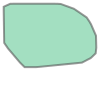

In [73]:
glas_gdf_chull

#### Compute intersection between all RGI polygons and the convex hull
Use the GeoDataFrame `intersects()` function.  
This will return a Boolean DataSeries, True if points intersect the polygon, False if they do not

In [74]:
rgi_gdf_idx = rgi_gdf.intersects(glas_gdf_chull)

In [75]:
rgi_gdf_idx.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

#### Extract records with True for the intersection

In [76]:
print("Number of RGI polygons before:",rgi_gdf.shape[0])
rgi_gdf_conus = rgi_gdf[rgi_gdf_idx]
print("Number of RGI polygons after:", rgi_gdf_conus.shape[0])

Number of RGI polygons before: 18855
Number of RGI polygons after: 5149


#### Quick plot to verify
Note latitude range

In [77]:
rgi_gdf_conus.plot(edgecolor='k', linewidth=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Part 4: Reprojection and Coordinate Systems

All of the above examples used standard geodetic lat/lon coordinate system (EPSG:4326).  This is fine for global analyses and basic visualization.  But remember that the width of a degree of longitude varies with latitude (~111 km near equator, ~0 m near pole), so our plots have scaling and aspect ratio issues.

We need to choose a map projection that is appropriate for our data. This decision is important for visualization, but is also critical for precise quantitative analysis. For example, if you want to compute area or volume change, you should use an equal-area projection. If you want to calculate distances between two points, you should use an equidistant projection.

https://www.axismaps.com/guide/general/map-projections/

Sadly, there is no "perfect" projection. You, as the mapmaker or data analyst, are responsible for choosing a projection with the right characteristics for your purposes. Let's explore a bit further, and we'll revisit some general guidelines later.

## Use GeoPandas to reproject your GeoDataFrame
* Use the very convenient `to_crs()` method to reproject: https://geopandas.org/projections.html
* Start by reprojecting the points to a Universal Transverse Mercator (UTM), Zone 10N (EPSG:32610)
* Store the output as a new GeoDataFrame
* Do a quick `head()` and note the new values in the `geometry` column

In [78]:
utm_crs = 'EPSG:32611'
glas_gdf_utm = glas_gdf.to_crs(utm_crs)

In [79]:
glas_gdf_utm.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (1431183.070 4955789.787)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (1431181.915 4954913.882)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (1431181.639 4954738.855)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (1431181.394 4954563.604)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (1431181.226 4954388.366)


## Create a new plot of the reprojected points
* Note the new coordinate system origin (0,0), units, and aspect ratio

In [80]:
ax = glas_gdf_utm.plot(column='glas_z', cmap='inferno', markersize=1, legend=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Excellent, but what did we just do?

Under the hood, GeoPandas used the `pyproj` library (a Python API for PROJ) to transform each point from one coordinate system to another coordinate system.  

I guarantee that you've all done this kind of thing before, you may just not remember it or recognize it in this context. See: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., WGS84 vs. UTM) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the `PROJ` library (https://proj.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use `PROJ`.

We aren't going to get into the details here, but feel free to take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj.org/operations/index.html

## Let's define a custom projection for the Western U.S.

The UTM projection we used above is not the best choice for our data, which actually span 4 UTM zones:
https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Utm-zones-USA.svg. 

We used Zone 11N, which means that our map will have limited distortion within that zone centered on -110°W.  But distortion will increase beyond the width of the -114° to -108°W zone definition.

Let's instead use a custom Albers Equal Area (AEA) projection to minimize distoration over the full spatial extent of our GLAS points

To do this, we'll define a PROJ string (https://proj.org/usage/quickstart.html?highlight=definition), which can be interpreted by most Python geopackages (like `pyproj`).

The Albers Equal Area projection requires two standard parallels: https://proj.org/operations/projections/aea.html.  Here, we will also specify the center latitude and center longitude for the coordinate system origin.

* Define a custom Albers Equal Area proj string `'+proj=aea...'`
    * https://en.wikipedia.org/wiki/Albers_projection
    * PROJ reference, with example: https://proj.org/operations/projections/aea.html
    * Here is another sample proj string example for an Albers Equal Area projection of the U.S. (note that this uses GRS80 ellipsoid and NAD83 datum): http://spatialreference.org/ref/esri/102003/proj4/
        * For your string, please use WGS84 ellipsoid (see the proj doc for aea in the above link)
* Use the center longitude and center latitude you calculated earlier
* Define the two standard parallels (lines of latitude) based on the range of your points
    * Scale is true along these parallels, and distortion increases as you move away from these two parallels
    * One approach would be to use min and max latitude from the `total_bounds` extent computed earlier
        * This is fine, but note that this could lead to additional distortion near your center latitude
        * Extra Credit: figure out how to place them slightly inside your min and max latitude to minimize distortion across the entire latitude range
* Use Python string formatting to dynamically create your proj string (don't just hardcode your values, but substitute variables in the string)
* Print the final proj string

## Get bounding box (extent) and center (lon, lat) of GLAS points
* See GeoPandas API reference. In this case, you want the total_bounds attribute: http://geopandas.org/reference.html#geopandas.GeoSeries.total_bounds
* Center can be calculated from the min/max extent values in each dimension

In [81]:
glas_extent = glas_gdf.total_bounds
glas_extent

array([-124.482406,   34.999455, -104.052336,   48.999727])

In [82]:
glas_center = glas_extent.reshape((2,2)).mean(axis=0)
glas_center

array([-114.267371,   41.999591])

## Create the PROJ string

In [83]:
clon = glas_center[0]
clat = glas_center[1]
#Standard parallels at min/max values
#p1 = glas_extent[1]
#p2 = glas_extent[3]
#Standard parallels within the point extent
dp = (glas_extent[3] - glas_extent[1])*0.67
p1 = clat - dp/2.
p2 = clat + dp/2.

In [84]:
proj_str_aea = '+proj=aea +lat_1={:.2f} +lat_2={:.2f} +lat_0={:.2f} +lon_0={:.2f}'.format(p1, p2, clat, clon)
proj_str_aea

'+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27'

## Reproject the GLAS points to the custom projection

In [85]:
glas_gdf_aea = glas_gdf.to_crs(proj_str_aea)

In [86]:
glas_gdf_aea.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (709799.202 277341.464)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (709764.987 276472.876)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (709758.108 276299.312)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (709751.251 276125.525)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (709744.472 275951.747)


In [87]:
bbox = glas_gdf_aea.total_bounds
bbox

array([-853172.2034737 , -772261.08660232,  881581.97159951,
        808966.82113798])

## Create scatter plots for each of the three projections (WGS84, UTM, and custom AEA)

In [88]:
f, axa = plt.subplots(1,3, figsize=(10,2.5))
glas_gdf.plot(ax=axa[0], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[0].set_title('WGS84')
axa[0].grid()
glas_gdf_utm.plot(ax=axa[1], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[1].set_title(utm_crs)
axa[1].grid()
glas_gdf_aea.plot(ax=axa[2], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[2].set_title('Albers Equal-area')
axa[2].grid()
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Umm, they kind of look the same.  Why are we wasting time on this?

* Note the location of the origin for each coordinate system
    * The (0,0) should be near the center of your points for the AEA projection
    * Where's the origin for the UTM projection?
* Note how azimuth and distances are distorted around edges of the plots

# Part 5: Spatial Aggregation

## Hexbin plots
Hexbin plots are nice option to visualize the spatial distribution of binned point density or other metric (e.g., median elevation) on a regular grid.  Later in the week, we'll learn about other interpolation and gridding options.

Hexagons are preferable over a standard square/rectangular grid: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-whyhexagons.htm

Also, see Sarah Battersby's publication on the topic (and appreciate one of the better journal article titles I've seen): https://doi.org/10.1080/15230406.2016.1180263

Here are some resources on generating hexbins using Python and matplotlib:
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
* http://darribas.org/gds15/content/labs/lab_09.html

Note: an equal-area projection is also a good idea for a hexbin plot.

In [89]:
nbins = 40

In [90]:
#To calculate number of bins dynamically with specified bin spacing in meters
#bin_width = 27000 #meters
#nbins_x = int(np.ceil(np.abs(bbox[2] - bbox[0])/bin_width))
#nbins_y = int(np.ceil(np.abs(bbox[3] - bbox[1])/bin_width))
#print(nbins_x, nbins_y)
#nbins = nbins_x

In [91]:
f,ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=nbins, cmap='inferno', bins='log', alpha=0.6, mincnt=1)
plt.colorbar(hb, label='Point Count')
states_gdf.to_crs(proj_str_aea).plot(ax=ax, facecolor='none', edgecolor='black');
#Limit plot extent to GLAS point bounds (note: ax.autoscale(False) doesn't work here)
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);
ax.set_title('GLAS Bin Point Count');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
f,ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_z'], \
               reduce_C_function=np.median, gridsize=nbins, cmap='inferno', alpha=0.6)
plt.colorbar(hb, ax=ax, label='Elevation (m HAE)')
states_gdf.to_crs(proj_str_aea).plot(ax=ax, facecolor='none', edgecolor='black');
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);
ax.set_title('GLAS Bin Median Elevation');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [93]:
f,ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_srtm_dhdt'], \
               reduce_C_function=np.median, gridsize=nbins, cmap='RdBu', alpha=0.6, vmin=-3, vmax=3)
plt.colorbar(hb, ax=ax, label='Elevation Change (m/yr)')
states_gdf.to_crs(proj_str_aea).plot(ax=ax, facecolor='none', edgecolor='black');
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);
ax.set_title('GLAS Bin Median Elevation');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Merge GLAS points with RGI polygons
Let's see if we can answer the following question:

*Can we identify CONUS glacier surface elevation change that occurred between SRTM (2000) and GLAS (2003-2009) data collection?*

Earlier we computed some statistics for the full CONUS GLAS sample and hex bins.  Now let's analyze the GLAS points that intersect each RGI glacier polygon. 

One approach would be to loop through each glacier polygon, and do an intersection operation with all points.  But this is inefficient, and doesn't scale well.  It is much more efficient to do a spatial join between the points and the polygons, then groupby and aggregate to compute the relevant statistics for all points that intersect each glacier polygon.

You may have learned how to perform a join or spatial join in a GIS course.  So, do we need to open ArcMap or QGIS here?  Do we need a full-fledged spatial database like PostGIS?  No!  GeoPandas has you covered.

* Start by reviewing the Spatial Join documentation here: http://geopandas.org/mergingdata.html
* Use the geopandas `sjoin` method: http://geopandas.org/reference/geopandas.sjoin.html

## First, we need to make sure all inputs have the same projection
* Reproject the RGI polygons to match our point CRS (custom Albers Equal-area)

In [94]:
rgi_gdf_conus_aea = rgi_gdf_conus.to_crs(glas_gdf_aea.crs)
states_gdf_aea = states_gdf.to_crs(glas_gdf_aea.crs)

### Optional: isolate relevant columns to simplify our output

In [95]:
glas_gdf_aea.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc', 'glas_srtm_dh', 'glas_srtm_dt', 'glas_srtm_dhdt', 'geometry'],
      dtype='object')

In [96]:
rgi_gdf_conus_aea.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry'],
      dtype='object')

In [97]:
glas_col = ['glas_z', 'glas_srtm_dhdt', 'geometry']
rgi_col = ['RGIId', 'Area', 'Name', 'geometry']

glas_gdf_aea_lite = glas_gdf_aea[glas_col]
rgi_gdf_conus_aea_lite = rgi_gdf_conus_aea[rgi_col]

## Now try a spatial join between these two 
* Use the GLAS points as the "left" GeoDataFrame and the RGI polygons as the "right" GeoDataFrame
* Start by using default options (`op='intersects', how='inner'`)
* Note the output geometry type and columns

In [98]:
glas_gdf_aea_rgi = gpd.sjoin(glas_gdf_aea_lite, rgi_gdf_conus_aea_lite)
glas_gdf_aea_rgi

,glas_z,glas_srtm_dhdt,geometry,index_right,RGIId,Area,Name
1032,1798.45,2.359970,POINT (-536290.697 765027.730),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5393,1826.79,-1.452545,POINT (-535829.928 764700.764),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5394,1795.05,-0.093358,POINT (-535841.258 764872.820),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5395,1768.91,0.194954,POINT (-535852.818 765044.784),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5396,1745.11,-0.118071,POINT (-535864.504 765216.980),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
...,...,...,...,...,...,...,...
61066,3549.78,-0.806986,POINT (-441710.217 -459198.891),15427,RGI60-02.15428,0.107,CA
63678,3537.09,-0.484384,POINT (-441728.079 -459143.781),15427,RGI60-02.15428,0.107,CA
61070,3506.14,0.040860,POINT (-441774.049 -458507.438),15419,RGI60-02.15420,0.043,CA
61100,3297.62,-1.074846,POINT (-443844.517 -433539.374),15640,RGI60-02.15641,0.056,CA


## Check number of records

In [99]:
print("Number of RGI polygons before:", rgi_gdf_conus_aea.shape[0])
print("Number of GLAS points before:", glas_gdf_aea.shape[0])
print("Number of GLAS points that intersect RGI polygons:", glas_gdf_aea_rgi.shape[0])

Number of RGI polygons before: 5149
Number of GLAS points before: 65236
Number of GLAS points that intersect RGI polygons: 822


## Check number of GLAS points per RGI polygon

In [100]:
glas_gdf_aea_rgi['RGIId'].value_counts()

RGI60-02.14588    49
RGI60-02.13805    45
RGI60-02.17727    43
RGI60-02.14005    33
RGI60-02.14103    30
                  ..
RGI60-02.13780     1
RGI60-02.17035     1
RGI60-02.14050     1
RGI60-02.15491     1
RGI60-02.15833     1
Name: RGIId, Length: 185, dtype: int64

## Which glacier has the greatest number of points?

Some notes on indexing and selecting from Pandas DataFrame: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

Here we'll use the `loc` function to pull out the record for the RGIId key with the highest point count.

In [101]:
label = glas_gdf_aea_rgi['RGIId'].value_counts().index[0]
print(label)

RGI60-02.14588


In [102]:
rgi_maxcount = rgi_gdf_conus_aea[rgi_gdf_conus_aea['RGIId'] == label].iloc[0]
rgi_maxcount

RGIId                                          RGI60-02.14588
GLIMSId                                        G237815E46186N
BgnDate                                              19809999
EndDate                                              -9999999
CenLon                                               -122.185
CenLat                                                46.1858
O1Region                                                    2
O2Region                                                    4
Area                                                    0.327
Zmin                                                     1990
Zmax                                                     2484
Zmed                                                     2261
Slope                                                    25.9
Aspect                                                    157
Lmax                                                     1088
Status                                                      0
Connect 

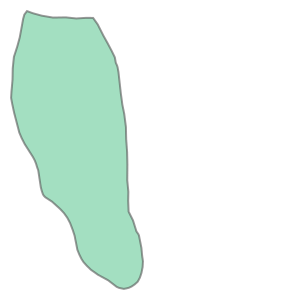

In [103]:
rgi_maxcount.geometry

## ipyleaflet plot

OK, great, but where is this glacier?  Let's plot on an interactive ipyleaflet map.

Note that leaflet uses tiled basemaps: https://en.wikipedia.org/wiki/Tiled_web_map 

Default projection is Web Mercator (EPSG:3857): https://en.wikipedia.org/wiki/Web_Mercator_projection.  This works well for lower latitudes, but not the polar regions.

FYI, `folium` provides similar functionality outside of the iPython/Jupyter stack: https://python-visualization.github.io/folium/

In [104]:
from ipyleaflet import Map, Marker, basemaps

In [105]:
#Look at all of the basemap options!
basemaps.keys()

dict_keys(['OpenStreetMap', 'OpenTopoMap', 'Hydda', 'Esri', 'HikeBike', 'MtbMap', 'CartoDB', 'NASAGIBS', 'Strava', 'Stamen'])

In [106]:
center = (rgi_maxcount['CenLat'], rgi_maxcount['CenLon'])
basemap = basemaps.Stamen.Terrain
m = Map(center=center, zoom=12, basemap=basemap)
#label=rgi_gdf_conus_aea.loc[label]['Name']
marker = Marker(location=center, draggable=True)
m.add_layer(marker);
display(m)

Map(center=[46.18581, -122.18532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Plot points and RGI polygons, Zoom in on WA state

In [107]:
wa_state = states_gdf_aea.loc[states_gdf_aea['NAME'] == 'Washington']
#wa_geom = wa_state.iloc[0].geometry

In [108]:
wa_bbox = wa_state.total_bounds

In [109]:
clim = (-3.0, 3.0)
ax=states_gdf_aea.plot(facecolor='none', edgecolor='black', linewidth=0.5);
rgi_gdf_conus_aea.plot(ax=ax, edgecolor='k', lw=0.5, alpha=0.1);
glas_gdf_aea.plot(ax=ax, column='glas_srtm_dhdt', cmap='RdBu', markersize=1, legend=True, vmin=clim[0], vmax=clim[1])
ax.set_xlim(wa_bbox[[0,2]]);
ax.set_ylim(wa_bbox[[1,3]]);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Groupby and Aggregate

OK, so we know that our sampling isn't great and our dh/dt values are noisy.  But we're here to learn some core concepts and tools, so let's compute some statistics for each glacier anyway.  Hopefully you'll see the value of these operations, and be able to reproduce in the future.

We can use the Pandas Groupby functionality to group GLAS points for each RGI polygon, and then aggregate using different functions (e.g., mean, std) for different attributes (e.g., 'glas_z', 'glas_srtm_dhdt').

This concept can feel a bit abstract at first, but it is very powerful.  

https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

In [110]:
glas_gdf_aea_rgi.head()

,glas_z,glas_srtm_dhdt,geometry,index_right,RGIId,Area,Name
1032,1798.45,2.359970,POINT (-536290.697 765027.730),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5393,1826.79,-1.452545,POINT (-535829.928 764700.764),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5394,1795.05,-0.093358,POINT (-535841.258 764872.820),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5395,1768.91,0.194954,POINT (-535852.818 765044.784),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5396,1745.11,-0.118071,POINT (-535864.504 765216.980),17368,RGI60-02.17369,2.819,Noisy Creek Glacier


In [111]:
glas_gdf_aea_rgi.groupby('RGIId')

Hmmm.  Nothing happened.  Ah, we need a function to perform the aggregation over the grouped data!  How about taking the mean?

In [112]:
glas_gdf_aea_rgi.groupby('RGIId').mean().head()

,glas_z,glas_srtm_dhdt,index_right,Area
RGIId,,,,
RGI60-02.13741,2367.762500,0.313717,13740,0.808
RGI60-02.13756,2334.240000,0.780945,13755,0.074
RGI60-02.13761,2577.600000,1.482302,13760,0.104
RGI60-02.13769,2710.566667,-0.500506,13768,0.051
RGI60-02.13770,2453.932500,0.282499,13769,0.144


## Define a more sophisticated aggregation function

A dictionary of fields and functions can be used to compute a set of summary statistics for relevant columns

In [113]:
agg_func = {'Name':'first',
            'Area':'first', 
            'glas_z':['mean', 'median', 'std', nmad],
            'glas_srtm_dhdt':['count','mean', 'median', 'std', nmad]}

In [114]:
glas_gdf_aea_rgi_agg = glas_gdf_aea_rgi.groupby('RGIId').agg(agg_func)

In [115]:
glas_gdf_aea_rgi_agg.head()

Name   Area       glas_z                        \
                             first  first         mean    median         std   
RGIId                                                                          
RGI60-02.13741   Hayden Glacier OR  0.808  2367.762500  2351.530   44.709595   
RGI60-02.13756                  OR  0.074  2334.240000  2309.530   40.594923   
RGI60-02.13761   Thayer Glacier OR  0.104  2577.600000  2577.600         NaN   
RGI60-02.13769  Villard Glacier OR  0.051  2710.566667  2689.840   54.160927   
RGI60-02.13770     Linn Glacier OR  0.144  2453.932500  2394.325  172.569776   

                          glas_srtm_dhdt                                \
                     nmad          count      mean    median       std   
RGIId                                                                    
RGI60-02.13741  42.698880             12  0.313717  0.521908  0.712847   
RGI60-02.13756  12.201798              7  0.780945  0.488872  1.156264   
RGI60-02.13761   0.000000              1  1.482302  1.482302       NaN   
RGI60-02.13769  29.666826              3 -0.500506 -0.549968  0.293306   
RGI60-02.13770  78.310932              4  0.282499  0.585407  0.806818   

                          
                    nmad  
RGIId                     
RGI60-02.13741  0.581288  
RGI60-02.13756  0.711884  
RGI60-02.13761  0.000000  
RGI60-02.13769  0.320194  
RGI60-02.13770  0.339207

In [116]:
# We don't need the multi-index here
glas_gdf_aea_rgi_agg.columns = ['_'.join(col).rstrip('_') for col in glas_gdf_aea_rgi_agg.columns.values]

In [117]:
glas_gdf_aea_rgi_agg.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_z_nmad,glas_srtm_dhdt_count,glas_srtm_dhdt_mean,glas_srtm_dhdt_median,glas_srtm_dhdt_std,glas_srtm_dhdt_nmad
RGIId,,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,42.698880,12,0.313717,0.521908,0.712847,0.581288
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,12.201798,7,0.780945,0.488872,1.156264,0.711884
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,0.000000,1,1.482302,1.482302,NaN,0.000000
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,29.666826,3,-0.500506,-0.549968,0.293306,0.320194
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,78.310932,4,0.282499,0.585407,0.806818,0.339207


In [118]:
glas_gdf_aea_rgi_agg['glas_pt_density'] = glas_gdf_aea_rgi_agg['glas_srtm_dhdt_count']/glas_gdf_aea_rgi_agg['Area_first']

## Wait a minute, what happened to our RGI polygon geometry?

This was a casualty of our initial spatial join, as we preserved the Point geometry for each GLAS record, not the RGI geometry.

Let's create a new GeoDataFrame, adding the original RGI geometry to the aggregated statistics.

Since both DataFrames have the same Index (RGIId), Pandas will automatically join with corresponding records.

In [119]:
rgi_gdf_conus_aea

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
13699,RGI60-02.13700,G254355E40030N,19539999,-9999999,-105.645100,40.030410,2,5,0.072,3736,...,109,334,0,0,0,0,0,1,Henderson Glacier CO,"POLYGON ((733183.856 -182439.954, 733180.014 -..."
13700,RGI60-02.13701,G254352E40023N,19539999,-9999999,-105.647800,40.023280,2,5,0.244,3694,...,95,622,0,0,0,0,0,1,Arapaho Glacier CO,"POLYGON ((733108.951 -183368.199, 733109.574 -..."
13701,RGI60-02.13702,G254358E40049N,19539999,-9999999,-105.641690,40.049200,2,5,0.053,3800,...,27,180,0,0,0,0,0,1,Arikaree Glacier CO,"POLYGON ((733034.552 -180342.957, 733033.152 -..."
13702,RGI60-02.13703,G254343E40060N,19539999,-9999999,-105.657160,40.060080,2,5,0.097,3482,...,8,566,0,0,0,0,0,1,Fair Glacier CO,"POLYGON ((731622.179 -179141.004, 731625.723 -..."
13703,RGI60-02.13704,G254335E40065N,19539999,-9999999,-105.665500,40.065250,2,5,0.061,3523,...,5,325,0,0,0,0,0,9,Peck Glacier CO,"POLYGON ((730885.006 -178746.016, 730892.426 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18850,RGI60-02.18851,G254352E40255N,20019999,-9999999,-105.648020,40.254766,2,5,0.030,3638,...,31,215,0,0,0,0,0,9,CO,"POLYGON ((730306.787 -157826.838, 730305.795 -..."
18851,RGI60-02.18852,G254364E40250N,20019999,-9999999,-105.636244,40.250242,2,5,0.013,3645,...,30,56,0,0,0,0,0,9,CO,"POLYGON ((731317.636 -158195.820, 731316.645 -..."
18852,RGI60-02.18853,G254382E40258N,20019999,-9999999,-105.618080,40.258485,2,5,0.012,4002,...,17,127,0,0,0,0,0,9,The Dove CO,"POLYGON ((732736.772 -157130.519, 732736.880 -..."
18853,RGI60-02.18854,G254389E40256N,20019999,-9999999,-105.611355,40.256107,2,5,0.031,3722,...,35,190,0,0,0,0,0,9,Mills Glacier CO,"POLYGON ((733299.328 -157350.202, 733299.221 -..."


In [120]:
rgi_gdf_conus_aea['geometry'].head()

13699    POLYGON ((733183.856 -182439.954, 733180.014 -...
13700    POLYGON ((733108.951 -183368.199, 733109.574 -...
13701    POLYGON ((733034.552 -180342.957, 733033.152 -...
13702    POLYGON ((731622.179 -179141.004, 731625.723 -...
13703    POLYGON ((730885.006 -178746.016, 730892.426 -...
Name: geometry, dtype: geometry

In [121]:
rgi_gdf_conus_aea[['RGIId','geometry']].set_index('RGIId')

,geometry
RGIId,
RGI60-02.13700,"POLYGON ((733183.856 -182439.954, 733180.014 -..."
RGI60-02.13701,"POLYGON ((733108.951 -183368.199, 733109.574 -..."
RGI60-02.13702,"POLYGON ((733034.552 -180342.957, 733033.152 -..."
RGI60-02.13703,"POLYGON ((731622.179 -179141.004, 731625.723 -..."
RGI60-02.13704,"POLYGON ((730885.006 -178746.016, 730892.426 -..."
...,...
RGI60-02.18851,"POLYGON ((730306.787 -157826.838, 730305.795 -..."
RGI60-02.18852,"POLYGON ((731317.636 -158195.820, 731316.645 -..."
RGI60-02.18853,"POLYGON ((732736.772 -157130.519, 732736.880 -..."


In [122]:
#A bit of a hack to join on RGIId 
glas_gdf_aea_rgi_agg_gdf = gpd.GeoDataFrame(glas_gdf_aea_rgi_agg, geometry=rgi_gdf_conus_aea[['RGIId','geometry']].set_index('RGIId')['geometry'])

In [123]:
glas_gdf_aea_rgi_agg_gdf.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_z_nmad,glas_srtm_dhdt_count,glas_srtm_dhdt_mean,glas_srtm_dhdt_median,glas_srtm_dhdt_std,glas_srtm_dhdt_nmad,glas_pt_density,geometry
RGIId,,,,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,42.698880,12,0.313717,0.521908,0.712847,0.581288,14.851485,"POLYGON ((-598133.617 265564.657, -598185.446 ..."
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,12.201798,7,0.780945,0.488872,1.156264,0.711884,94.594595,"POLYGON ((-597218.162 266082.680, -597213.111 ..."
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,0.000000,1,1.482302,1.482302,NaN,0.000000,9.615385,"POLYGON ((-596960.080 266987.222, -596972.553 ..."
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,29.666826,3,-0.500506,-0.549968,0.293306,0.320194,58.823529,"POLYGON ((-597525.689 267742.830, -597539.484 ..."
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,78.310932,4,0.282499,0.585407,0.806818,0.339207,27.777778,"POLYGON ((-597605.776 268593.766, -597632.421 ..."


# Let's make some final maps

## Import some other useful mapping packages

`matplotlib-scalebar` adds a dynamic scalebar to matplotlib axes

`contextily` downloads and statically renders basemap tiles

In [124]:
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

In [125]:
def add_basemap(ax, crs, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    ctx.add_basemap(ax=ax, crs=crs, url=ctx.sources.ST_TERRAIN)
    #Create a scalebar object, with scaling factor of 1.0 px, since we're using projected coordinate system with unit 1 m
    scalebar = ScaleBar(1.0)
    #Add scalebar to axes
    ax.add_artist(scalebar)

In [126]:
import contextily as ctx
f, ax = plt.subplots()
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=2, legend=True)
#Add basemap, specifying crs keyword
add_basemap(ax, crs=glas_gdf_aea.crs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [127]:
clim = (-5.0, 5.0)
f, axa = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

rgi_gdf_conus_aea.plot(ax=axa[0], edgecolor='k', facecolor='w', lw=0.5, alpha=0.2);
glas_gdf_aea_rgi_agg_gdf.plot(ax=axa[0],column='glas_srtm_dhdt_count', cmap='inferno', edgecolor='k', lw=0.5, legend=True)
axa[0].set_title('Number of GLAS shots per RGI Polygon')
add_basemap(axa[0], glas_gdf_aea.crs)

glas_gdf_aea_rgi_agg_gdf.plot(ax=axa[1],column='glas_srtm_dhdt_median', cmap='RdBu', edgecolor='k', lw=0.5, vmin=clim[0], vmax=clim[1], legend=True)
axa[1].set_title('Median SRTM to GLAS dh/dt (m/yr)')
glas_gdf_aea_rgi.plot(ax=axa[1],column='glas_srtm_dhdt', cmap='RdBu', markersize=5, edgecolor='0.5', lw=0.5, vmin=clim[0], vmax=clim[1])
states_gdf_aea.plot(ax=axa[1], edgecolor='k', facecolor='none', lw=0.5)

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Zoom to North Cascades

# Can we extract any additional insight from the reduced data?

## Point density vs. Glacier Area

*Do we see more valid GLAS points over bigger glaciers?*

In [128]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_count'])
ax.set_ylabel('Number of GLAS shots')
ax.set_xlabel('Glacier Area (km^2)');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Median dh/dt vs. Glacier Area

Do we see less elevation change over bigger glaciers?

In [129]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_median'])
ax.set_xlabel('Glacier Area (km^2)')
ax.set_ylabel('Median SRTM - GLAS dh/dt (m/yr)')
ax.axhline(0, color='k');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Median dh/dt vs. Glacier Elevation

*Do we see greater elevation loss at lower elevations?*

In [130]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['glas_z_median'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_median'])
ax.set_xlabel('Median Glacier Elevation (m HAE)')
ax.set_ylabel('Median SRTM - GLAS dh/dt (m/yr)')
ax.axhline(0, color='k');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Conclusion:

N/A

# Save the final polygons to a GIS-ready file

The workflows in these Notebooks are intended to be fully reproducible, starting with raw data and producing all final output.  But sometimes you want to write out geospatial data for analysis in a GUI-based GIS (QGIS, ArcMap), or to share with colleagues who will use these tools.

## Check available output formats for geopandas
* Use fiona to get a list of available file type drivers for output
* Note: the 'r' means fiona/geopandas can read this file type, 'w' means it can write this file type, 'a' means it can append to an existing file.
    * https://fiona.readthedocs.io/en/latest/manual.html#writing-vector-data

In [131]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

## How to choose a format?
* If you've taken a GIS class (or not), you've probably used shapefiles in the past.  Please stop.  The ESRI shapefile is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and simple GeoJSON for other cases
    * Both should be supported by your GIS (including QGIS, ArcGIS, etc)
* Let's use geopackage for this exercise
* Can use the Geopandas `to_file()` method to create this file
    * Make sure you properly specify filename with extension and the `driver` option
    * *Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file*
        * Can see this in the file browser or terminal!

In [132]:
out_fn='./conus_glas_gdf_aea_rgi_agg.gpkg'
glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GPKG')

#out_fn='./conus_glas_gdf_aea_rgi_agg.geojson'
#glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GeoJSON')

In [133]:
ls -lh $out_fn

-rw-r--r-- 1 jovyan root 816K Jun 12 05:22 ./conus_glas_gdf_aea_rgi_agg.gpkg


## 🎉

You can now directly load this gpkg file in any GIS, without defining a coordinate system. You can also load this file directly into geopandas in the future using the `read_file()` method, without having to repeat the processing above.

### See for yourself!
Try it! Right-click on file in the file browser to the left of the JupyterLab interface, then select Download and pick a location on your local computer (e.g., your Downloads folder). 

Then open this file in QGIS or ArcGIS on your local machine!

# So, what if we actually had a decent GLAS sample of CONUS glaciers?

## Estimate glacier mass balance

We could estimate mass balance for each glacier polygon using the mean dh/dt, glacier area, and a standard bulk density (e.g., 850 kg/m3 [Huss, 2013]).  Could then use geopandas to perform a secondary aggregation to compile statistics for polygons representing mountain ranges, river basins, etc.

With a sparse sample, probably best to derive dh/dt vs. elevation curves, then combine with observed glacier hypsometry to estimate mass balance for glacier polygons.  This can work, but need to be careful about spatial variability.

# Final thoughts

GLAS was not the right tool for small, low-latitude CONUS glaciers.  We kind of knew this would be the case before we started, but hey, it was worth a look, and we learned some basic Python geospatial analysis skills.

The concepts and approaches presented here can be applied to larger glaciers or ice caps, especially at higher latitudes.  One could modify to repeat for all RGI regions.

We started with an existing csv of culled points here.  One could repeat with a similarly processed subset of ATL06 points using the workflows presented earlier this week.  This will provide a longer time period to evaluate noisy elevation measurements.  Replacing void-filled SRTM with another reference DEM is also needed (e.g., the timestamped USGS NED).

Note that the core tools presented here have Dask integration (https://dask.org/) to allow you to chunk and process larger-than-memory datasets with minimal modification to the code.

## Other visualization packages for large point datasets
* Datashader
* ipyvolume
* hvplot

# Appendix A: Distortion in Polar Stereographic Projections

"The [polar stereographic] projection is defined on the entire sphere, except at one point: the projection point. Where it is defined, the mapping is smooth and bijective. It is conformal, meaning that it preserves angles at which curves meet. It is neither isometric nor area-preserving: that is, it preserves neither distances nor the areas of figures." [Wikipedia]

Many of you are probably using polar stereographic projections, likely the standard EPSG:3031 or EPSG:3413 projections for Antarctica and Greenland, respectively.  These are designed to minimize distortion near the latitude of true scale (71°S for Antarctica and 70°N for Greenland).  This means that area and distance distortion will increase as you move away from this latitude.  So areas or distances measured near the pole will not be equivalent to areas or distances measured on the Antarctic Peninsula.  The difference isn't huge, but is nontrivial (~1-2% for Antarctica I believe).  See https://nsidc.org/data/polar-stereo/ps_grids.html for more details.

The figures here might help illustrate: https://en.wikipedia.org/wiki/Stereographic_projection#Properties

Let's try to illustrate this nuanced, but often overlooked issue.

## Tissot's Indicatrix for polar stereographic projection

Let's use the classic Tissot's Indicatrix plots to show map distortion.

https://en.wikipedia.org/wiki/Tissot%27s_indicatrix

In [134]:
import cartopy
import cartopy.crs as ccrs

#Cartopy implementation of EPSG:3031 and EPSG:3413
crs_3031 = ccrs.SouthPolarStereo(true_scale_latitude=-71)
crs_3413 = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

#Circle locations
lons = range(-180, 180, 30)
lats = range(-90, 91, 10)
#Radius of circles
rad = 400

In [135]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1, projection=crs_3413)
ax1.coastlines()
ax1.gridlines(ylocs=[70,],color='r')
ax1.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax1.set_title('EPSG:3413')

ax2 = plt.subplot(1, 2, 2, projection=crs_3031)
ax2.coastlines()
ax2.gridlines(ylocs=[-71,],color='r')
ax2.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax2.set_title('EPSG:3031')
ax2.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#There is a bug in cartopy extent when central_longitude is not 0
#Get extent in projected crs (x0, x1, y0, y1)
extent_3413 = ax2.get_extent()
ax1.set_extent(extent_3413, crs_3413)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## OK, cool plot bro.  But why does this matter?

Note the size of the circles in the corners and over the pole, relative to the circles near the latitude of true scale (red line).  While it is unlikely that you'll use this projection to look at mid-latitude regions, you can see the difference in area distortion over the ~20° of latitude between North and South Greenland.

Say you generated amazing elevation difference grids for all of the Greenland ice sheet using ICESat and ICESat-2 crossovers, and you used the EPSG:3413 projection.  Say the grids have a posting (grid cell size) of 120 m.  Imagine didividing the above plots into grid cells.  You'll end up with more grid cells over the circles at lower latitudes (e.g., South Greenland) and fewer grid cells over circles at high latitudes (e.g., North Greenland).  

Let's put it another way.  You could try to compute volume change of the Greenland ice sheet by summing dh/dt values for all grid cells in each catchment.  Let's assume all grid cells have the same -1.0 m/yr value.  The integrated estimates for the catchments in South Greenland will have more grid cells due to the projection, resulting in larger apparent negative volume change!

## Let's compare with an equal-area projection
Lambert Azimuthal Equal-Area is not a bad choice for the polar regions

In [136]:
#Cartopy implementation of EPSG:3031 and EPSG:3413
#crs_slaea = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
crs_nlaea = ccrs.LambertAzimuthalEqualArea(central_longitude=-45.0, central_latitude=90.0)

#Specify locations of Tissot's Indicatrix
lons = range(-180, 180, 30)
lats = range(-90, 91, 10)
rad = 400

In [137]:
#Add a 100 km grid
dx = 100000
xgrid = np.arange(extent_3413[0], extent_3413[1]+dx, dx)
ygrid = np.arange(extent_3413[2], extent_3413[3]+dx, dx)

In [138]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1, projection=crs_3413)
ax1.coastlines()
ax1.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax1.set_title('EPSG:3413')
#ax1.gridlines(crs=ccrs.PlateCarree(), ylocs=lats)
ax1.gridlines(crs=crs_3413, xlocs=xgrid, ylocs=ygrid)
ax1.gridlines(ylocs=[70,],color='r')

ax2 = plt.subplot(1, 2, 2, projection=crs_nlaea)
ax2.coastlines()
ax2.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax2.set_title('Lambert Azimuthal Equal-Area')
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
#ax2.gridlines(crs=ccrs.PlateCarree(), ylocs=lats)
ax2.gridlines(crs=crs_nlaea, xlocs=xgrid, ylocs=ygrid)

#ax1.set_extent(extent_3413, crs_3413)
#ax2.set_extent(extent_3413, crs_3413)

gr_extent = [-1.4E6,1.4E6,-3.7E6,-5.3E5]
ax1.set_extent(gr_extent, crs_3413)
ax2.set_extent(gr_extent, crs_3413)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Not the distorted shape of the circles near Southern Greenland, though they should have identical area.

## Bonus: the "Flat Earth" Projection: Azimuthal Equidistant

![Azimuthal Equidistant](https://upload.wikimedia.org/wikipedia/commons/2/2f/Flat_earth.png)

>An azimuthal equidistant projection of the entire spherical Earth. A rendered picture of the Flat Earth model. The white around the outside of the globe is thought to be an 'Ice Wall', preventing people from falling off the surface of the earth. [Wikipedia]

So, those of you who have been to the South Pole, can you help me understand how this works?

# Appendix B: Sampling a raster at points

This is something that is surprisingly common, but may not be simple to implement.  Let's discuss a few options:
1. Simple `rasterio` sampling with integer indices using nearest neighbor
2. Statistics extracted for a circular window around each point location
3. NumPy/SciPy interpolation routines

For this example, we will use a sample 90-m SRTM-GL1 DEM over WA state, but you could repeat with any DEM (e.g., ArcticDEM)

## 1. Rasterio sampling

In [139]:
import os
import rasterio as rio
from rasterio import plot

### Open the file with rasterio

https://rasterio.readthedocs.io/en/stable/

In [140]:
srtm_fn = '/srv/shared/SRTM3_wa_mosaic_utm.tif'

In [141]:
#This is rasterio Dataset object
srtm_src = rio.open(srtm_fn)

In [142]:
srtm_src.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 11298, 'height': 8406, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(69.75777310180744, 0.0, 342369.35927004984,
       0.0, -69.75777310180744, 5569366.822198175), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [143]:
srtm_src.crs

CRS.from_epsg(32610)

In [144]:
srtm_extent = rio.plot.plotting_extent(srtm_src)

### Read as a NumPy Masked array

In [145]:
srtm = srtm_src.read(1, masked=True)

In [146]:
srtm

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-32768,
  dtype=int16)

### Create a quick plot

In [147]:
f, ax = plt.subplots()
ax.imshow(srtm, extent=srtm_extent);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Generate shaded relief map
* Many ways to do this, but we'll just use the `gdaldem` command line utility for simplicity

In [148]:
hs_fn = os.path.splitext(srtm_fn)[0]+'_hs.tif'
!gdaldem hillshade $srtm_fn $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [149]:
srtm_hs_src = rio.open(hs_fn)
hs = srtm_hs_src.read(1, masked=True)

## Plot color shaded relief map

In [150]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
ax.imshow(srtm, extent=srtm_extent, alpha=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Reproject GLAS points to match raster

In [151]:
glas_gdf_srtm = glas_gdf_aea.to_crs(srtm_src.crs)

### Prepare the coordinate arrays to pass to rio `sample` function
* The `sample` function expects a list of (x,y) tuples: https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
    * Need to create this from the `geometry` objects in your GeoDataFrame
    * You want a list of the form [(x1,y1),(x2,y2),…]
* Pass to `sample`
* Note that the `sample` function returns a `generator` object, and it doesn't actually evaluate the call!
* Can wrap this in a `np.array(list())` to evaluate, or use `np.fromiter()`
* This operation may take ~10-20 seconds to complete

In [152]:
glas_coord = [(pt.x, pt.y) for pt in glas_gdf_srtm.geometry]
#glas_coord = np.vstack((glas_gdf_srtm.geometry.x.values, glas_gdf_srtm.geometry.y.values)).T

### Sample with rasterio

In [153]:
glas_srtm_sample = srtm_src.sample(glas_coord)
glas_srtm_sample

<generator object sample_gen at 0x7fe849306a50>

### This is a generator, so we actually need to evaluate

In [154]:
glas_srtm_elev = np.fromiter(glas_srtm_sample, dtype=srtm.dtype)
glas_srtm_elev

array([-32768, -32768, -32768, ..., -32768, -32768, -32768], dtype=int16)

### Deal with nodata
* Some of our GLAS points are located over areas where we don't have valid DEM pixels
* These will be assigned the raster nodata value (-32768 in this case)

In [172]:
glas_srtm_elev_ma = np.ma.masked_equal(glas_srtm_elev, srtm_src.nodata)
glas_srtm_elev_ma

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=-32768,
            dtype=int16)

### Add new column to the GeoDataFrame
* Set masked values to `np.nan` (which requires a conversion to float)

In [156]:
glas_gdf_srtm['srtm_90m_z_rio'] = glas_srtm_elev_ma.astype(float).filled(np.nan)

In [157]:
glas_gdf_srtm.dropna().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,srtm_90m_z_rio
471,2003.143756,731268.470840,46.304107,-124.040358,-23.92,-23.73,0.00,31,-0.19,3.031756,-0.062670,POINT (419885.336 5128362.681),1.0
483,2003.143756,731268.471078,47.574649,-124.316324,86.25,52.15,6.86,31,34.10,3.031756,11.247606,POINT (401004.504 5269865.469),94.0
484,2003.143756,731268.471078,47.576197,-124.316654,114.96,96.83,9.48,31,18.13,3.031756,5.980032,POINT (400982.605 5270037.926),132.0
485,2003.143756,731268.471103,47.707542,-124.345717,79.83,73.15,2.38,31,6.68,3.031756,2.203343,POINT (399050.384 5284672.588),100.0
486,2003.143756,731268.471103,47.709092,-124.346068,85.99,69.48,4.03,31,16.51,3.031756,5.445688,POINT (399027.048 5284845.308),104.0


In [176]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
#ax.imshow(srtm, extent=srtm_extent, alpha=0.5);
glas_gdf_srtm.dropna().plot('srtm_90m_z_rio', ax=ax, markersize=1);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

*Note: the SRTM elevation values are height above the EGM96 geoid*

### Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses a nearest neighbor algorithm to extract the elevation value for the grid cell that contains the point, regardless of where the point falls within the grid cell (center vs. corner)
* But the DEM grid cells can be big (~90x90 m for the SRTM3 data), so if point is near the corner of a pixel on steep slope, the pixel value might not be representative.
* A better approach is to use bilinear or bicubic sampling, to interpolate the elevation value at the point coordinate using pixel values within some neighborhood around the point, (e.g. 2x2 window for bilinear, 4x4 window for cubic)
* Other approaches involve computing zonal stats within some radius of the point location (e.g., median elevation of pixels within 300 m of the point, using buffer to create polygons)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/
    * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#getting-values-at-cells
    * https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

## 2. Local window sample

https://github.com/dshean/demcoreg/blob/master/demcoreg/sample_raster_at_pts.py

https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019